In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA, FastICA

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage

In [2]:
df=pd.read_csv('pc_data.csv')
df.head()

,EPC1,EPC2,EPC3,Usage,Payment,Calls,Region,Age
0,50,67,25,0.86,1,3,North,25
1,45,78,47,0.94,0,1,Center,13
2,47,71,33,0.91,0,2,Center,20
3,42,73,54,0.94,0,1,Center,18
4,36,65,32,0.94,0,2,North,21


In [55]:
df.describe()

,EPC1,EPC2,EPC3,Usage,Payment,Calls,Age,Consumes
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,40.711000,67.437000,29.001000,0.631030,0.109000,1.235000,33.281000,137.149000
std,11.135685,22.577861,13.359771,0.273306,0.311795,0.901436,9.816741,27.207334
min,19.000000,22.000000,9.000000,0.100000,0.000000,0.000000,12.000000,51.000000
25%,32.000000,52.000000,14.000000,0.280000,0.000000,1.000000,26.000000,134.000000
50%,42.000000,65.000000,31.000000,0.745000,0.000000,1.000000,35.000000,143.000000
75%,49.000000,78.000000,40.000000,0.790000,0.000000,2.000000,41.000000,151.000000
max,76.000000,112.000000,55.000000,0.950000,1.000000,3.000000,48.000000,187.000000


1. EPC1- kitchen (dishwasher, oven, microwave, refrigerator)
2. EPC2- laundry room (washing-machine, tumble-drier)
3. EPC3- air system (electric water-heater, air-conditioner)
4. Usage- % of energy consumption from 8.00 am to 8.00 pm
5. Payment- regular (0), unpaid invoices in the last 3 months (1)
6. Calls- number of call-center calls in the last 12 months (1,2,3)
7. Region- area in which the households ives (North, Center, South)
8. Age- number of months from activation of plan

# Inspecting the dataset

## Region analysis

In [4]:
regions=df.groupby('Region')

In [5]:
regions['Usage'].mean().round(3)

Region
Center    0.736
North     0.494
South     0.749
Name: Usage, dtype: float64

households in the northern region tend to consume more in the nights

In [6]:
regions['Usage'].count()

Region
Center    268
North     450
South     282
Name: Usage, dtype: int64

households in the north count of 45% of the whole dataset

In [7]:
tot_consumes=regions[['EPC1','EPC2','EPC3']].mean().round(2)
tot_consumes['TOT']=tot_consumes['EPC1']+tot_consumes['EPC2']+tot_consumes['EPC3']
tot_consumes

,EPC1,EPC2,EPC3,TOT
Region,,,,
Center,42.16,66.85,31.31,140.32
North,38.92,67.12,26.35,132.39
South,42.20,68.50,31.03,141.73


households in the north are those who consume the least in general terms, but for EPC2 is still quite aligned with the rest of the regions

In [8]:
regions['Payment'].sum()

Region
Center    13
North     79
South     17
Name: Payment, dtype: int64

households in the north are the ones with more payment issues

## Calls -- 2 or 3 

In [9]:
df2=df.loc[df['Calls'].isin([2,3])]

x=df2.Calls
colors='Set1'

#df2

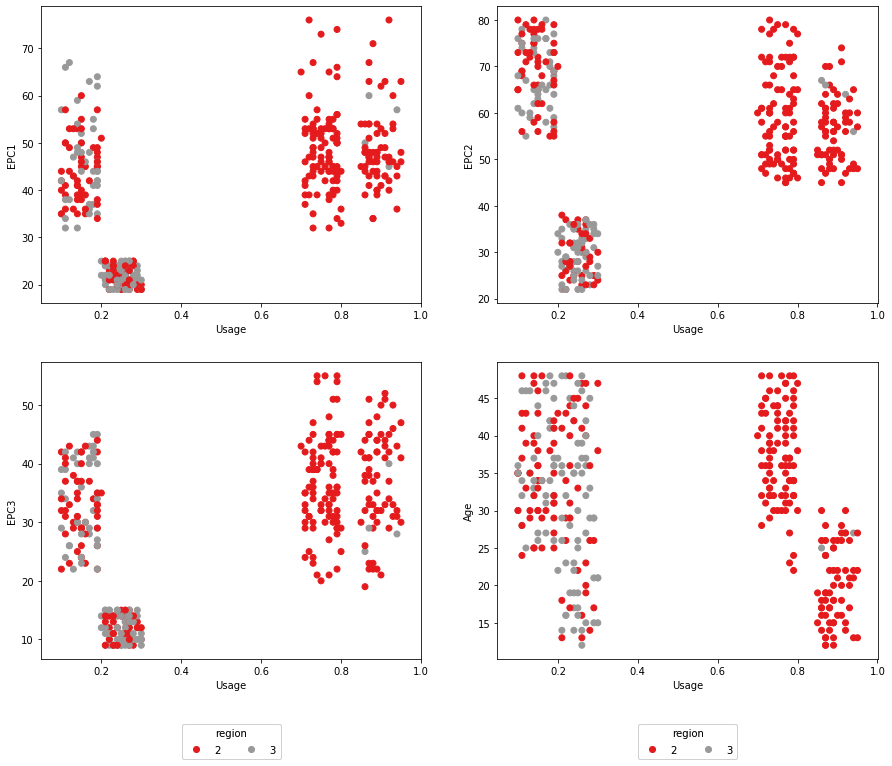

In [10]:
fig=plt.figure(figsize=(15,12))
ax=fig.add_subplot(2,2,1)
g=ax.scatter(df2.Usage,df2.EPC1, c=x, cmap=colors)
ax.set_xlabel('Usage')
ax.set_ylabel('EPC1')
legend = ax.legend(*g.legend_elements(), loc="lower center", title="region", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

ax=fig.add_subplot(2,2,2)
g=ax.scatter(df2.Usage,df2.EPC2, c=x, cmap=colors)
ax.set_xlabel('Usage')
ax.set_ylabel('EPC2')
legend = ax.legend(*g.legend_elements(), loc="lower center", title="region", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

ax=fig.add_subplot(2,2,3)
g=ax.scatter(df2.Usage,df2.EPC3, c=x, cmap=colors)
ax.set_xlabel('Usage')
ax.set_ylabel('EPC3')
legend = ax.legend(*g.legend_elements(), loc="lower center", title="region", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

ax=fig.add_subplot(2,2,4)
g=ax.scatter(df2.Usage,df2.Age, c=x, cmap=colors)
ax.set_xlabel('Usage')
ax.set_ylabel('Age')
legend = ax.legend(*g.legend_elements(), loc="lower center", title="region", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

relevant: 3 recent calls per customer are more concentrated in night usage and little consumes

# Data Prepration

1. categorical: region
2. dummy: payment
3. numerical: EPC1, EPC2, EPC3, Usage, Calls, Age <br><br>


We want to focus on consumes, so we decided to aggregate EPC1, EPC2, EPC3 <br><br> 

to be standardized: consumes, Age 

In [11]:
df['Consumes']=df.EPC1+df.EPC2+df.EPC3
data=df.iloc[:,3:9]
data.head()

,Usage,Payment,Calls,Region,Age,Consumes
0,0.86,1,3,North,25,142
1,0.94,0,1,Center,13,170
2,0.91,0,2,Center,20,151
3,0.94,0,1,Center,18,169
4,0.94,0,2,North,21,133


### Handling categorical

In [12]:
d=data[['Region']]
dummy=pd.get_dummies(d)
#dummy

### Scaling -- best fit: StandardScaler

In [13]:
to_convert=data[['Age','Consumes']]

from sklearn.preprocessing import StandardScaler
scaler= StandardScaler().fit(to_convert)
scaled=scaler.transform(to_convert)
scaled=pd.DataFrame(scaled).round(2)
scaled.columns=to_convert.columns
#scaled.head()

### New data after preprocessing

In [14]:
energy=pd.concat([scaled,df.Usage,df.Calls,df.Payment,dummy],axis=1)
energy.head()

,Age,Consumes,Usage,Calls,Payment,Region_Center,Region_North,Region_South
0,-0.84,0.18,0.86,3,1,0,1,0
1,-2.07,1.21,0.94,1,0,1,0,0
2,-1.35,0.51,0.91,2,0,1,0,0
3,-1.56,1.17,0.94,1,0,1,0,0
4,-1.25,-0.15,0.94,2,0,0,1,0


# 1. K-means cluster technique

distortion 1 : 3630.35
distortion 2 : 2573.23
distortion 3 : 1926.85
distortion 4 : 1587.54
distortion 5 : 1415.73
distortion 6 : 1245.09
distortion 7 : 1150.71
distortion 8 : 1072.25
distortion 9 : 990.16
distortion 10 : 940.8


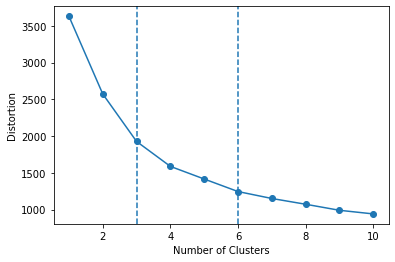

In [15]:
distorsions = [] #empty list

for i in range(1,11):
    km = KMeans(n_clusters=i, init ='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(energy)
    distorsions.append(km.inertia_)
    print('distortion',i,':',km.inertia_.round(2))
plt.plot(range(1,11), distorsions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.axvline(x=3, linestyle='--')
plt.axvline(x=6, linestyle='--')
plt.show()

silh score: 2 0.46
silh score: 3 0.273
silh score: 4 0.28
silh score: 5 0.269
silh score: 6 0.314
silh score: 7 0.307
silh score: 8 0.304
silh score: 9 0.292
silh score: 10 0.265


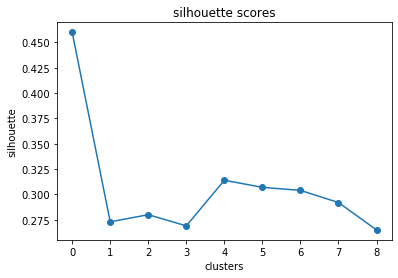

In [16]:
#calculating silh scores for 2 to 11 clusters
silh=[]
for j in range(2,11):
    km = KMeans(n_clusters=j, 
                init='random',  #init=’k-means++’ 
                n_init=10, 
                max_iter=300, 
                tol=1e-04, 
                random_state=0) #init=’k-means++’ see notes below

    km.fit(energy) #Compute k-means clustering.
    y_km = km.predict(energy) 
    cluster_labels = np.unique(y_km)


    silhouette_vals = silhouette_samples(energy, y_km, metric='euclidean')

    y_ax_lower, y_ax_upper=0,0
    ss=silhouette_score(energy,y_km,metric='euclidean').round(3)
    print('silh score:', j,ss )
    silh.append(ss)

#plotting silh scores
plt.plot(silh, marker='o')
plt.title('silhouette scores')
plt.xlabel('clusters')
plt.ylabel('silhouette')
plt.show()

Most suitable: 6 clusters

In [17]:
km = KMeans(n_clusters=6, 
            init='random',  #init=’k-means++’ 
            n_init=10, 
            max_iter=300, 
            tol=1e-04, 
            random_state=0) #init=’k-means++’ see notes below

km.fit(energy) #Compute k-means clustering.
clusters = km.predict(energy) 
#clusters

In [18]:
energy['Clusters']=clusters
energy_resorted=energy.sort_values('Clusters')
compare=energy_resorted.groupby('Clusters')

In [19]:
c=compare.count().cumsum()
compare.count()

,Age,Consumes,Usage,Calls,Payment,Region_Center,Region_North,Region_South
Clusters,,,,,,,,
0,207,207,207,207,207,207,207,207
1,192,192,192,192,192,192,192,192
2,100,100,100,100,100,100,100,100
3,190,190,190,190,190,190,190,190
4,130,130,130,130,130,130,130,130
5,181,181,181,181,181,181,181,181


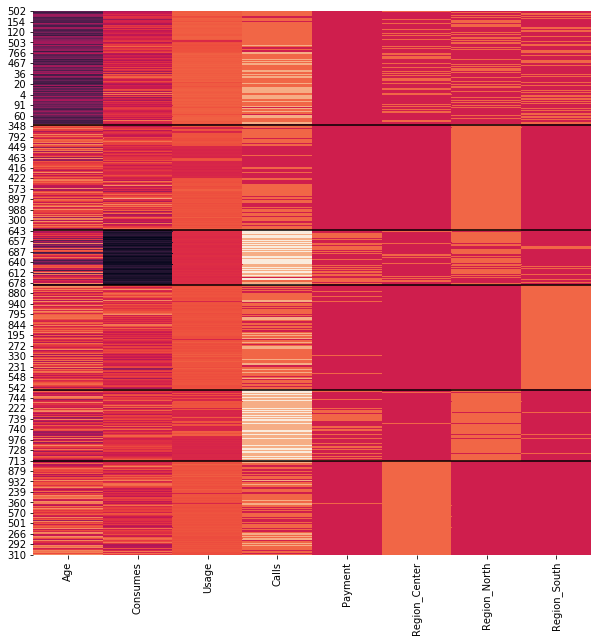

In [20]:
plt.figure(figsize=(10,10))
e=energy_resorted.drop(['Clusters'],1)
ax=sns.heatmap(e,cbar=False)
ax.hlines(c['Age'], *ax.get_xlim())
plt.show()

In [21]:
compare.mean().round(2)

,Age,Consumes,Usage,Calls,Payment,Region_Center,Region_North,Region_South
Clusters,,,,,,,,
0,-1.40,0.14,0.86,1.21,0.00,0.32,0.30,0.37
1,0.47,0.34,0.56,0.54,0.02,0.00,1.00,0.00
2,-0.29,-2.71,0.25,2.53,0.51,0.17,0.72,0.11
3,0.52,0.33,0.74,0.91,0.03,0.00,0.00,1.00
4,0.17,0.34,0.36,2.34,0.34,0.02,0.95,0.03
5,0.59,0.39,0.74,0.84,0.02,1.00,0.00,0.00


Clusters:
    5. troublemakers: relatively new contracts, with very low consumes and quite annoying with high number of calls; mostly in the north; typically consuming in the night hours
    4. central region: tend to use daily appliances, relatively old contracts and high consumes
    3. issue-related customers: high number of calls and tend to use appliances in the night, standard consumes. mostly in the north
    2. northern region: long-term contracts, standard consumes, no general payment issues. Still, there must be a general tendency to use more night appliances
    1. southern region: longest-term contracts, standard consumes, no general payment issues, generally consumes in the daily hours
    0. newest contracts,very low consumes during the day (mostly); well distributed across the areas

# 2. Hierachical clustering technique -- ward distance

silh for 2 clusters: 0.401
silh for 3 clusters: 0.459
silh for 4 clusters: 0.414
silh for 5 clusters: 0.417
silh for 6 clusters: 0.467
silh for 7 clusters: 0.449
silh for 8 clusters: 0.417
silh for 9 clusters: 0.434
silh for 10 clusters: 0.393


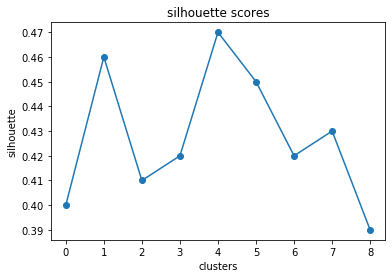

In [22]:
#calculating silhouette for 2 to 11 clusters
silh=[]
for i in range(2,11):
    cl=AgglomerativeClustering(linkage='ward',n_clusters=i)
    ward=cl.fit(energy).labels_
    print('silh for',i, 'clusters:',silhouette_score(energy,ward).round(3))
    silh.append(silhouette_score(energy,ward).round(2))

#plotting silh scores
plt.plot(silh, marker='o')
plt.title('silhouette scores')
plt.xlabel('clusters')
plt.ylabel('silhouette')
plt.show()

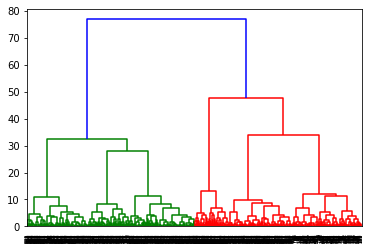

In [23]:
from scipy.cluster.hierarchy import dendrogram
dend = dendrogram(linkage(energy, method='ward'))

In [24]:
cl=AgglomerativeClustering(linkage='ward',n_clusters=6)
ward=cl.fit(energy).labels_
    
energy['Clusters']=ward

In [25]:
energy_resorted=energy.sort_values('Clusters')
compare=energy_resorted.groupby('Clusters')

In [26]:
d=compare.count().cumsum()
compare.count()

,Age,Consumes,Usage,Calls,Payment,Region_Center,Region_North,Region_South
Clusters,,,,,,,,
0,100,100,100,100,100,100,100,100
1,207,207,207,207,207,207,207,207
2,194,194,194,194,194,194,194,194
3,192,192,192,192,192,192,192,192
4,182,182,182,182,182,182,182,182
5,125,125,125,125,125,125,125,125


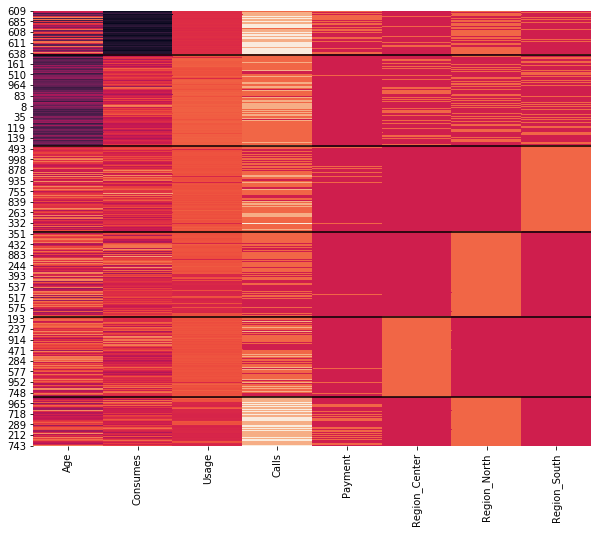

In [53]:
plt.figure(figsize=(10,8))
e=energy_resorted.drop('Clusters',1)
ax=sns.heatmap(e,cbar=False)
ax.hlines(d['Age'], *ax.get_xlim())
plt.show()

In [28]:
compare.mean().round(2)

,Age,Consumes,Usage,Calls,Payment,Region_Center,Region_North,Region_South
Clusters,,,,,,,,
0,-0.29,-2.71,0.25,2.53,0.51,0.17,0.72,0.11
1,-1.40,0.14,0.86,1.21,0.00,0.32,0.30,0.37
2,0.51,0.33,0.74,0.94,0.05,0.00,0.00,1.00
3,0.47,0.34,0.56,0.54,0.02,0.00,1.00,0.00
4,0.59,0.39,0.74,0.85,0.03,1.00,0.00,0.00
5,0.16,0.34,0.36,2.33,0.31,0.02,0.98,0.00


**final conclusion:** aggregating for consumes and standard preprocessing, 6 clusters appear to be a good fit, calculated better with a hierarchical cluster (silh: 0.46)

# Feature Extraction --PCA

In [29]:
energy.head()

,Age,Consumes,Usage,Calls,Payment,Region_Center,Region_North,Region_South,Clusters
0,-0.84,0.18,0.86,3,1,0,1,0,5
1,-2.07,1.21,0.94,1,0,1,0,0,1
2,-1.35,0.51,0.91,2,0,1,0,0,1
3,-1.56,1.17,0.94,1,0,1,0,0,1
4,-1.25,-0.15,0.94,2,0,0,1,0,1


In [30]:
pca=PCA()

In [31]:
energy=energy.drop(['Clusters'],1)
pca.fit(energy)
pca_en=pd.DataFrame(pca.transform(energy))

pca_en.columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']

In [32]:
exp_var=pd.DataFrame(pca.explained_variance_ratio_).round(2).transpose()
exp_var

,0,1,2,3,4,5,6,7
0,0.4,0.26,0.14,0.1,0.08,0.02,0.01,0.0


In [33]:
cumulative=np.cumsum(pca.explained_variance_ratio_).round(2)
pd.DataFrame(cumulative).transpose()

,0,1,2,3,4,5,6,7
0,0.4,0.66,0.8,0.89,0.97,0.99,1.0,1.0


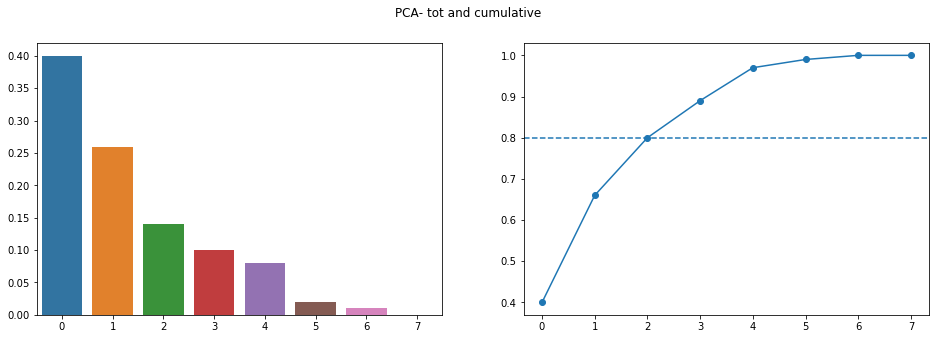

In [34]:
%matplotlib inline
fig=plt.figure(figsize=(16,5))
fig.suptitle('PCA- tot and cumulative')

#explained variance
ax = fig.add_subplot(1,2,1)
g=sns.barplot(data=exp_var)

#cumulative explained variance
ax=fig.add_subplot(1,2,2)
g=plt.plot(cumulative, marker='o')
plt.axhline(y=0.80, ls='--')

In [35]:
pd.DataFrame(pca.components_,
             index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'],
             columns=energy.columns).round(2)

,Age,Consumes,Usage,Calls,Payment,Region_Center,Region_North,Region_South
PC1,-0.39,-0.70,-0.08,0.57,0.11,-0.05,0.11,-0.06
PC2,0.91,-0.31,-0.12,0.19,0.10,-0.03,0.09,-0.06
PC3,-0.03,-0.64,0.02,-0.74,-0.05,0.10,-0.15,0.06
PC4,-0.07,0.02,-0.16,-0.26,0.02,-0.34,0.77,-0.43
PC5,-0.01,0.03,0.01,0.03,-0.02,0.73,-0.04,-0.68
PC6,-0.07,0.10,-0.37,-0.13,0.90,0.06,-0.10,0.04
PC7,0.05,-0.04,0.90,-0.00,0.40,-0.05,0.12,-0.07
PC8,-0.00,0.00,0.00,-0.00,0.00,-0.58,-0.58,-0.58


PC1: troublemaker-- calls a lot, consumes a little, relatively new <br>
PC2: long age little consumes-- long-term contracts, less consumes <br>
PC3: cheap contracts-- little consumes but no troubles shown to callcenter <br>
PC4: location-- whether is in the north (+) or mid-south (-)

In [36]:
new_df=pca_en.iloc[:,0:4]
new_df.columns=['troublemaker','ageOrConsumes','cheap_contract','location']
new_df.head()

,troublemaker,ageOrConsumes,cheap_contract,location
0,1.381101,-0.360994,-1.567284,0.222901
1,-0.277742,-2.397428,-0.398165,-0.288682
2,0.505157,-1.333125,-0.713783,-0.615193
3,-0.448235,-1.919149,-0.388196,-0.326777
4,1.078724,-0.929042,-0.545562,0.472510


### K-means

silh score: 2 0.498
silh score: 3 0.318
silh score: 4 0.333
silh score: 5 0.327
silh score: 6 0.327
silh score: 7 0.294
silh score: 8 0.323
silh score: 9 0.3
silh score: 10 0.327


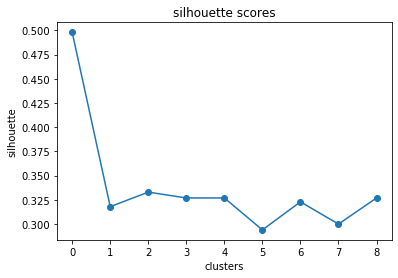

In [37]:
silh=[]
for j in range(2,11):
    km = KMeans(n_clusters=j, 
                init='random',  #init=’k-means++’ 
                n_init=10, 
                max_iter=300, 
                tol=1e-04, 
                random_state=0) #init=’k-means++’ see notes below

    km.fit(new_df) #Compute k-means clustering.
    y_km = km.predict(new_df) 
    cluster_labels = np.unique(y_km)


    silhouette_vals = silhouette_samples(new_df, y_km, metric='euclidean')

    y_ax_lower, y_ax_upper=0,0
    ss=silhouette_score(new_df,y_km,metric='euclidean').round(3)
    print('silh score:', j,ss )
    silh.append(ss)

#plotting silh scores
plt.plot(silh, marker='o')
plt.title('silhouette scores')
plt.xlabel('clusters')
plt.ylabel('silhouette')
plt.show()

In [38]:
km = KMeans(n_clusters=4, 
            init='random',  #init=’k-means++’ 
            n_init=10, 
            max_iter=300, 
            tol=1e-04, 
            random_state=0) #init=’k-means++’ see notes below

km.fit(new_df) #Compute k-means clustering.
clusters = km.predict(new_df) 
#clusters

In [39]:
new_df['Clusters']=clusters
new_df_res=new_df.sort_values('Clusters')
compare=new_df_res.groupby('Clusters')

C:\Users\Utente\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
p=compare.count().cumsum()
compare.count()

,troublemaker,ageOrConsumes,cheap_contract,location
Clusters,,,,
0,461,461,461,461
1,250,250,250,250
2,100,100,100,100
3,189,189,189,189


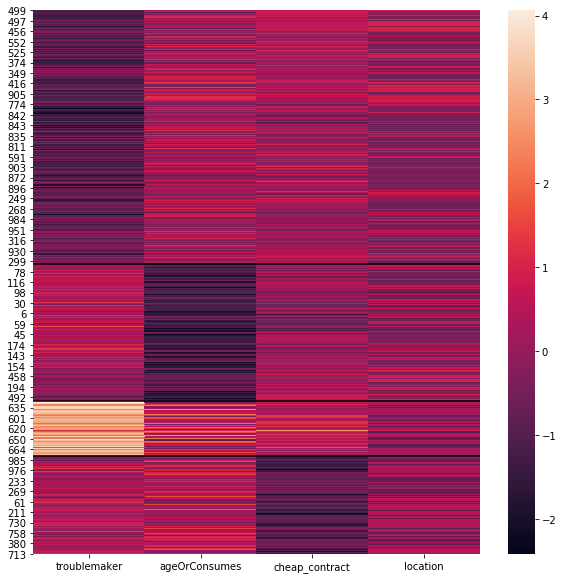

In [41]:
plt.figure(figsize=(10,10))
e=new_df_res.drop('Clusters',1)
ax=sns.heatmap(e)
ax.hlines(p['troublemaker'], *ax.get_xlim())
plt.show()

In [42]:
compare.mean().round(2)

,troublemaker,ageOrConsumes,cheap_contract,location
Clusters,,,,
0,-0.89,0.30,0.23,0.03
1,0.28,-1.25,0.05,-0.04
2,2.86,0.93,0.69,0.00
3,0.29,0.44,-1.01,-0.02


In [43]:
dt_plot=new_df
dt=new_df
X=new_df.troublemaker
Y=new_df.ageOrConsumes
Z=new_df.cheap_contract

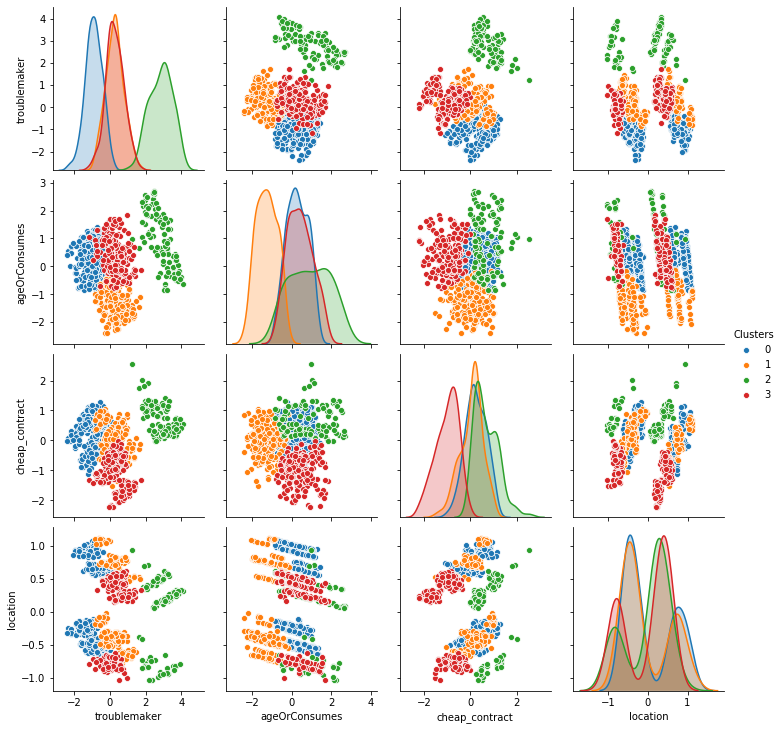

In [44]:
sns.pairplot(new_df, hue='Clusters')

### Hierarchical clustering

In [45]:
new_df=new_df.drop(['Clusters'],1)
new_df.head()

,troublemaker,ageOrConsumes,cheap_contract,location
0,1.381101,-0.360994,-1.567284,0.222901
1,-0.277742,-2.397428,-0.398165,-0.288682
2,0.505157,-1.333125,-0.713783,-0.615193
3,-0.448235,-1.919149,-0.388196,-0.326777
4,1.078724,-0.929042,-0.545562,0.472510


silh for 2 clusters: 0.498
silh for 3 clusters: 0.451
silh for 4 clusters: 0.408
silh for 5 clusters: 0.256
silh for 6 clusters: 0.18
silh for 7 clusters: 0.166
silh for 8 clusters: 0.163
silh for 9 clusters: 0.167
silh for 10 clusters: 0.165


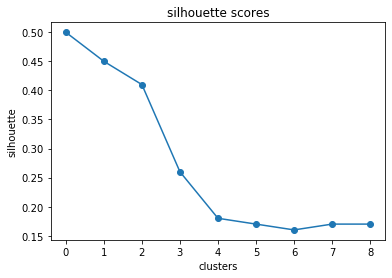

In [46]:
#calculating silhouette for 2 to 11 clusters
silh=[]
for i in range(2,11):
    cl=AgglomerativeClustering(linkage='single',n_clusters=i)
    ward=cl.fit(new_df).labels_
    print('silh for',i, 'clusters:',silhouette_score(new_df,ward).round(3))
    silh.append(silhouette_score(new_df,ward).round(2))

#plotting silh scores
plt.plot(silh, marker='o')
plt.title('silhouette scores')
plt.xlabel('clusters')
plt.ylabel('silhouette')
plt.show()

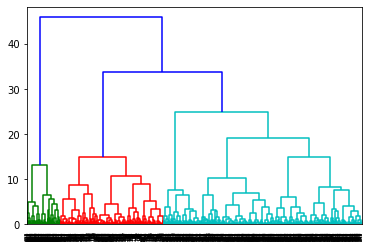

In [47]:
from scipy.cluster.hierarchy import dendrogram
dend = dendrogram(linkage(new_df, method='ward'))

In [48]:
cl=AgglomerativeClustering(linkage='ward',n_clusters=4)
ward=cl.fit(new_df).labels_
    
new_df['Clusters']=ward

In [49]:
new_df_res=new_df.sort_values('Clusters')
compare=new_df_res.groupby('Clusters')

In [50]:
q=compare.count().cumsum()
compare.count()

,troublemaker,ageOrConsumes,cheap_contract,location
Clusters,,,,
0,481,481,481,481
1,100,100,100,100
2,308,308,308,308
3,111,111,111,111


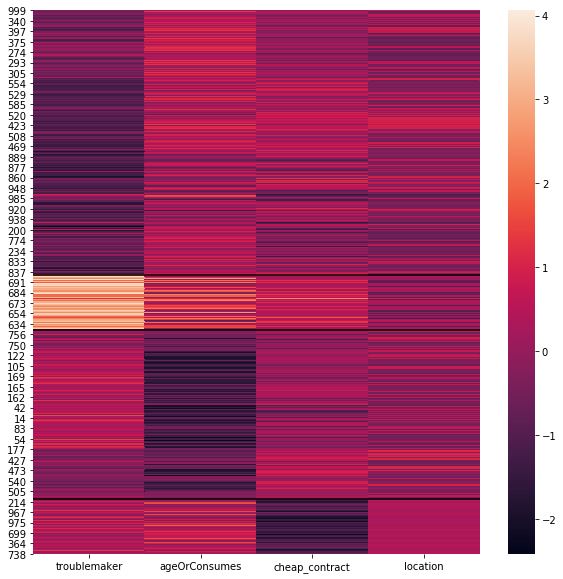

In [51]:
plt.figure(figsize=(10,10))
e=new_df_res.drop('Clusters',1)
ax=sns.heatmap(e)
ax.hlines(q['troublemaker'], *ax.get_xlim())
plt.show()

In [52]:
compare.mean()

,troublemaker,ageOrConsumes,cheap_contract,location
Clusters,,,,
0,-0.820554,0.384577,0.087890,-0.082328
1,2.857602,0.931244,0.690964,0.004401
2,0.193707,-1.075000,0.068447,-0.011350
3,0.443822,0.477424,-1.193271,0.384285


**final conclusion:** pca appears to be less understandable and quite hard to relate it to real-world consumes